In [2]:
import pandas as pd
from fastai.tabular.all import *

In [3]:
df = pd.read_csv('titanic-dataset/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We need to put data in *DataLoaders* (dls) class in fastai. To do that, we have wrapper around *DataLoader* for tabular datam which is called *TabularDataLoaders*

In [4]:
splits = RandomSplitter(seed=42)(df)
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [5]:
"""
y_block = CategoryBlock() - our target value is encoded (survived or not survived), so we need to explicitly pass this value so fastai won't presume we are doing regression
"""
tp = TabularPandas(
    df,
    splits=splits,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=['Pclass', 'Sex', 'Embarked'],
    cont_names=['Age', 'SibSp', 'Parch', 'Fare'],
    y_names='Survived',
    y_block=CategoryBlock()
)

In [6]:
tp

     PassengerId  Survived  Pclass                                   Name  \
788          789         1       3             Dean, Master. Bertram Vere   
525          526         0       3                     Farrell, Mr. James   
821          822         1       3                      Lulic, Mr. Nikola   
253          254         0       3               Lobb, Mr. William Arthur   
374          375         0       3             Palsson, Miss. Stina Viola   
..           ...       ...     ...                                    ...   
770          771         0       3                 Lievens, Mr. Rene Aime   
414          415         1       3              Sundman, Mr. Johan Julian   
540          541         1       1                Crosby, Miss. Harriet R   
298          299         1       1                  Saalfeld, Mr. Adolphe   
489          490         1       3  Coutts, Master. Eden Leslie "Neville"   

     Sex       Age     SibSp     Parch             Ticket      Fare Cabin  

In [7]:
# Create DataLoaders instead of TabularPandas object
dls = tp.dataloaders(bs=64)

In [8]:
dls.show_batch()

,Pclass,Sex,Embarked,Age_na,Age,SibSp,Parch,Fare,Survived
0,3,male,S,True,28.000000,1.689237e-09,-9.897945e-09,7.895800,0
1,3,male,S,False,43.999999,1.689237e-09,-9.897945e-09,8.049999,0
2,1,female,C,False,17.000000,1.000000e+00,-9.897945e-09,108.900004,1
3,1,male,C,False,58.000000,1.689237e-09,2.000000e+00,113.274999,0
4,3,male,C,False,20.000000,1.689237e-09,-9.897945e-09,7.229200,1
5,2,male,S,False,69.999999,1.689237e-09,-9.897945e-09,10.500000,0
6,3,male,Q,True,28.000000,1.689237e-09,-9.897945e-09,7.750000,1
7,3,male,S,False,51.000000,1.689237e-09,-9.897945e-09,7.750000,0
8,2,female,S,False,30.000000,1.689237e-09,-9.897945e-09,13.000001,1
9,3,male,S,False,32.000000,1.689237e-09,-9.897945e-09,7.925000,0


### Model Training

In [9]:
# Create a learner  using dls with specific metric
learner = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.03981071710586548, valley=0.009120108559727669)

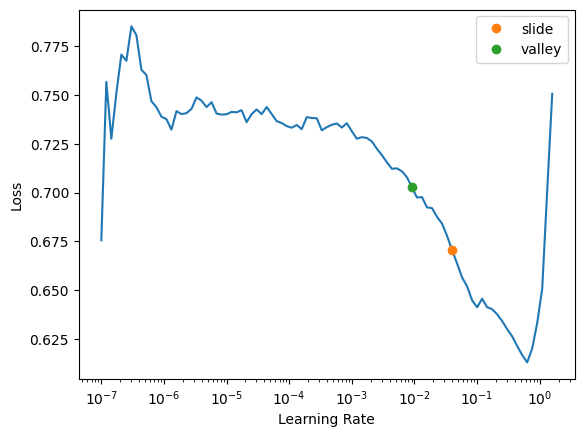

In [10]:
learner.lr_find(suggest_funcs=(slide, valley))

In [11]:
learner.fit(16, lr=0.03)

In [12]:
# We can save model as .pkl file
learner.export(fname='exportLearner.pkl')

### Submit

In [13]:
test_df = pd.read_csv('titanic-dataset/test.csv')
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [14]:
# There are NaN value in 'Fare' but not in setup training set
test_df['Fare'] = test_df.Fare.fillna(0)
test_df.Fare.isna().sum()

0

In [15]:
learner.dls.test_dl

<bound method TabularDataLoaders.test_dl of <fastai.tabular.data.TabularDataLoaders object at 0x7efd4c1fcf40>>

In [16]:
# test_dl method apply all processing steps on test set. No need to manually change anything
test_dls = learner.dls.test_dl(test_df)

In [17]:
test_dls.__dict__

{'after_item': Pipeline: ,
 'before_batch': Pipeline: ,
 'after_batch': Pipeline: ReadTabBatch,
 '__stored_args__': {'dataset':      PassengerId  Pclass                                          Name  Sex  \
  0            892       3                              Kelly, Mr. James    2   
  1            893       3              Wilkes, Mrs. James (Ellen Needs)    1   
  2            894       2                     Myles, Mr. Thomas Francis    2   
  3            895       3                              Wirz, Mr. Albert    2   
  4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    1   
  ..           ...     ...                                           ...  ...   
  413         1305       3                            Spector, Mr. Woolf    2   
  414         1306       1                  Oliva y Ocana, Dona. Fermina    1   
  415         1307       3                  Saether, Mr. Simon Sivertsen    2   
  416         1308       3                           Ware, Mr. F

In [18]:
# get predictions
preds,_ = learner.get_preds(dl=test_dls)

In [19]:
preds;

In [20]:
# Create a submission CSV for Kaggle
test_df['Survived'] = (preds[:, 1]>0.5).int()
sub_df = test_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [21]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
